In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
import seaborn as sns
import os
import warnings
from math import ceil
warnings.filterwarnings('ignore')

from scipy.stats import uniform

from IPython.display import display, HTML, Markdown
sns.set_palette("Paired")

In [6]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [7]:
# Merged dataset

df = pd.read_csv('Datasets/Granular/NF-UQ-NIDS.csv', sep=',')
len(df)

11994893

In [8]:
y = df.iloc[:,-3].to_numpy() #only binary, 0-normal, 1-abnormal;  [-2]-->attack specification
X = df.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Label', 'Attack', 'Dataset'], axis=1).to_numpy()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)

In [7]:
# We'd like to have side by side comparison of accuracy and avg f1-score for the classifiers we trained
def compare_results(results):
    sns.set_style("darkgrid")

    plt.subplots(1, 2, figsize=(12, 8))
    plt.subplot(1, 2, 1)

    ax = sns.barplot(x='classifier', y='accuracy', hue='data', data=results)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
    ax.set(title='Dokładność klasyfikatorów dla zbioru testowego i treningowego', ylabel='Dokładność', xlabel='Klasyfikator')
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
    plt.ylim(.5, 1.05)


    plt.subplot(1, 2, 2)
    ax = sns.barplot(x='classifier', y='weighted_avg_f1-score', hue='data', data=results)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
    ax.set(title='Średnia ważona f1-score dla klasyfikatorów dla zbioru testowego i treningowego', ylabel='Śr. ważon f1-score', xlabel='Klasyfikator')
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

    plt.ylim(.5, 1.05)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=1.2, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)

    plt.show()

# training / testing wrapper, so it would be easier to train multiple classifiers and stash the results
def test_clf(func, X_train, y_train, X_test, y_test):
    def inner(*args, **kwargs):

        mpl.rcParams.update(mpl.rcParamsDefault)

        clf = func(*args, **kwargs) # Constructor of model


        
        clf = clf.fit(X_train, y_train)
        name = f'{clf.best_estimator_.__class__.__name__} with {clf.__class__.__name__}' if hasattr(clf, 'best_estimator_') else clf.__class__.__name__
        y_pred = clf.predict(X_test)
        y_training_pred = clf.predict(X_train)

        disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
        disp.ax_.set(title=f'Confusion Matrix for {name}')
        plt.show()

        
        # Creating a report for current model 
        report_test = classification_report(y_test, y_pred, output_dict=True)
        report_train = classification_report(y_train, y_training_pred, output_dict=True)

        report_result = [{
                "classifier": name, 
                "weighted_avg_f1-score": report_test['weighted avg']['f1-score'],
                "accuracy": report_test['accuracy'],
                "data": "test"
            }, {
                "classifier": name, 
                "weighted_avg_f1-score": report_train['weighted avg']['f1-score'],
                "accuracy": report_train['accuracy'],
                "data": "train"
        } ]
        return report_result

    return inner

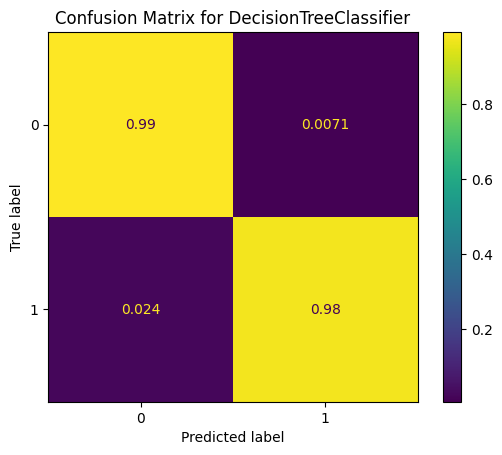

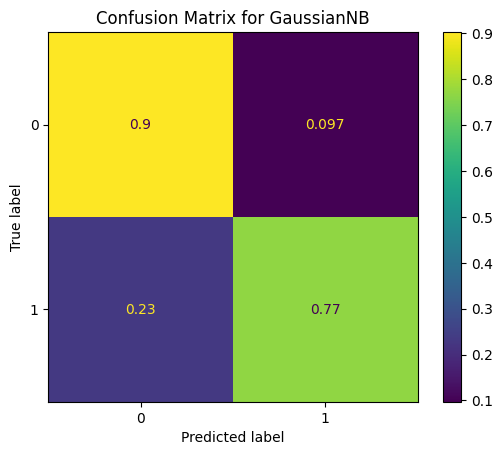

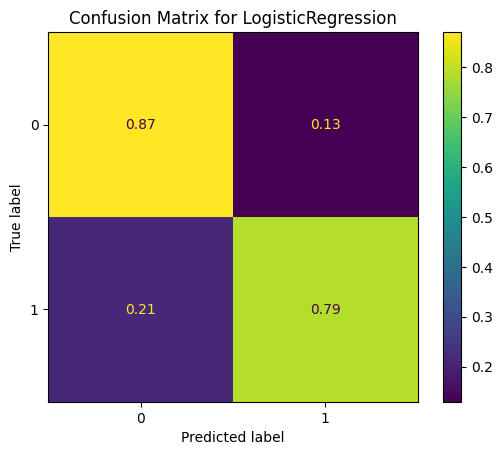

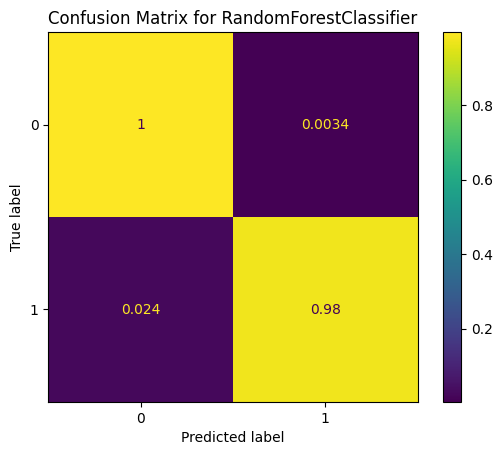

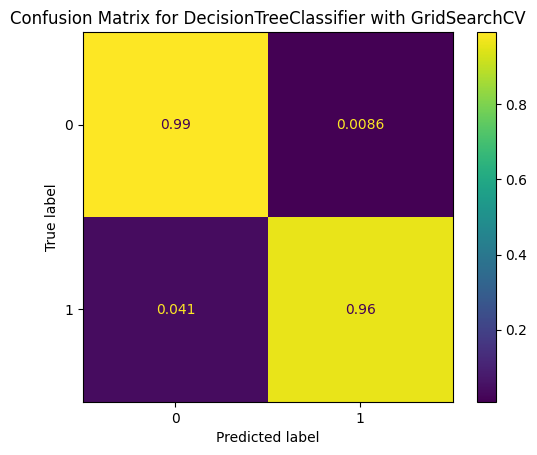

In [ ]:
rs_param_logistic_reg = {"C": uniform(loc=0, scale=4),
            "penalty": ['l1', 'l2', 'elasticnet'],
            "solver": ['lbfgs', 'liblinear', 'sag']}



param_grid_dec_tree = {'max_features': ['auto', 'sqrt', 'log2', None],
                    'ccp_alpha': [0.1, .01, .001],
                    'criterion' :['gini', 'entropy']}


# list of models to try
clfs = [
    (DecisionTreeClassifier, {}),
    (GaussianNB, {}),
    (LogisticRegression, {}),
    (RandomForestClassifier, {}),
    (GridSearchCV, dict(estimator=DecisionTreeClassifier(), param_grid=param_grid_dec_tree, cv=5)),
    (RandomizedSearchCV, dict(estimator=LogisticRegression(), param_distributions=rs_param_logistic_reg, cv=5))
]

# run training/testing wrapper and collect/aggregate reports
results = pd.DataFrame([report for clf, kwargs in\
                        clfs for report in\
                        test_clf(clf, X_train, y_train, X_test, y_test)(**kwargs)])

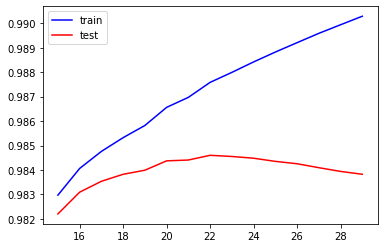

10


In [16]:
from sklearn import tree
from sklearn.metrics import f1_score


classifiers, scores_train, scores_test = [],[],[]
reports_train, reports_test = [],[]
depths= np.arange(15,30)

for depth in depths:
    classifier = DecisionTreeClassifier(random_state=0,max_depth=depth)
    
    classifier.fit(X_train,y_train)
    classifiers.append(classifier)
    
    y_pred_train = classifier.predict(X_train)
    y_pred_test = classifier.predict(X_test)
    
    scores_train.append(f1_score(y_train, y_pred_train))
    scores_test.append(f1_score(y_test, y_pred_test))
    
    reports_train.append(classification_report(y_train, y_pred_train))
    reports_test.append(classification_report(y_test, y_pred_test))
    
    #scores_train.append(classifier.score(X_train,y_train))
    #scores_test.append(classifier.score(X_test,y_test))
    
    
    
plt.plot(depths, scores_train, c='b', label='train')
plt.plot(depths, scores_test, c='r', label='test')
plt.legend()
plt.show()


print(3 + np.argmax(scores_test))

#Najlepszy 3, który jest 0 elementem obiektu classifiers
trees = classifiers[0]

#fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30,10), dpi=600)
#tree.plot_tree(trees)
#fig.savefig('tree_clf.png')
                        


In [17]:
for i in reports_train:
    print(i)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99   6445552
           1       0.99      0.97      0.98   1950873

    accuracy                           0.99   8396425
   macro avg       0.99      0.99      0.99   8396425
weighted avg       0.99      0.99      0.99   8396425

              precision    recall  f1-score   support

           0       0.99      1.00      1.00   6445552
           1       0.99      0.97      0.98   1950873

    accuracy                           0.99   8396425
   macro avg       0.99      0.99      0.99   8396425
weighted avg       0.99      0.99      0.99   8396425

              precision    recall  f1-score   support

           0       0.99      1.00      1.00   6445552
           1       1.00      0.97      0.98   1950873

    accuracy                           0.99   8396425
   macro avg       0.99      0.99      0.99   8396425
weighted avg       0.99      0.99      0.99   8396425

              preci

In [18]:
for i in reports_test:
    print(i)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99   2762496
           1       0.99      0.97      0.98    835972

    accuracy                           0.99   3598468
   macro avg       0.99      0.98      0.99   3598468
weighted avg       0.99      0.99      0.99   3598468

              precision    recall  f1-score   support

           0       0.99      1.00      0.99   2762496
           1       0.99      0.97      0.98    835972

    accuracy                           0.99   3598468
   macro avg       0.99      0.99      0.99   3598468
weighted avg       0.99      0.99      0.99   3598468

              precision    recall  f1-score   support

           0       0.99      1.00      1.00   2762496
           1       0.99      0.97      0.98    835972

    accuracy                           0.99   3598468
   macro avg       0.99      0.99      0.99   3598468
weighted avg       0.99      0.99      0.99   3598468

              preci